In [12]:
!pip install torch torchvision torchaudio
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2023-11-06 18:54:11--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py.12’

     0K ...                                                   100% 26.7M=0s

2023-11-06 18:54:12 (26.7 MB/s) - ‘engine.py.12’ saved [4063/4063]

--2023-11-06 18:54:12--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]

0 Conv2dNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
1 InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
2 InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2dNormActivation(
    

200 OK
Length: 23628 (23K) [text/plain]
Saving to: ‘transforms.py.12’

     0K .......... .......... ...                             100% 1.38M=0.02s

2023-11-06 18:54:20 (1.38 MB/s) - ‘transforms.py.12’ saved [23628/23628]



In [21]:
import os
import torch
import utils
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import torchvision
from torchvision.transforms import v2 as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from engine import train_one_epoch, evaluate


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        img = tv_tensors.Image(img)
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return len(self.imgs)
def get_model(num_classes):
    backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
    backbone.out_channels = 1280
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2,
    )
    model = FasterRCNN(
        backbone,
        num_classes=2,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
    )

    return model

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

model = get_model(num_classes=2)

dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 5
for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions)

Epoch: [0]  [ 0/60]  eta: 0:14:35  lr: 0.000090  loss: 1.4273 (1.4273)  loss_classifier: 0.6573 (0.6573)  loss_box_reg: 0.0303 (0.0303)  loss_objectness: 0.7013 (0.7013)  loss_rpn_box_reg: 0.0384 (0.0384)  time: 14.5850  data: 0.0231
Epoch: [0]  [10/60]  eta: 0:15:53  lr: 0.000936  loss: 1.4273 (1.3921)  loss_classifier: 0.6150 (0.5854)  loss_box_reg: 0.0797 (0.0680)  loss_objectness: 0.6932 (0.6889)  loss_rpn_box_reg: 0.0387 (0.0497)  time: 19.0737  data: 0.0404
Epoch: [0]  [20/60]  eta: 0:11:58  lr: 0.001783  loss: 1.2294 (1.2425)  loss_classifier: 0.4215 (0.4500)  loss_box_reg: 0.0938 (0.1014)  loss_objectness: 0.6611 (0.6474)  loss_rpn_box_reg: 0.0373 (0.0438)  time: 18.1371  data: 0.0384
Epoch: [0]  [30/60]  eta: 0:08:48  lr: 0.002629  loss: 0.9781 (1.1331)  loss_classifier: 0.2628 (0.3894)  loss_box_reg: 0.1353 (0.1181)  loss_objectness: 0.5161 (0.5829)  loss_rpn_box_reg: 0.0373 (0.0427)  time: 16.8361  data: 0.0351
Epoch: [0]  [40/60]  eta: 0:05:55  lr: 0.003476  loss: 0.8340 (1

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:01:06  model_time: 1.2955 (1.2955)  evaluator_time: 0.0127 (0.0127)  time: 1.3311  data: 0.0223
Test:  [49/50]  eta: 0:00:00  model_time: 0.7645 (0.8479)  evaluator_time: 0.0031 (0.0042)  time: 0.8566  data: 0.0155
Test: Total time: 0:00:43 (0.8681 s / it)
Averaged stats: model_time: 0.7645 (0.8479)  evaluator_time: 0.0031 (0.0042)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:33  model_time: 0.6497 (0.6497)  evaluator_time: 0.0095 (0.0095)  time: 0.6796  data: 0.0200
Test:  [49/50]  eta: 0:00:00  model_time: 0.7914 (0.7904)  evaluator_time: 0.0033 (0.0035)  time: 0.7853  data: 0.0124
Test: Total time: 0:00:40 (0.8075 s / it)
Averaged stats: model_time: 0.7914 (0.7904)  evaluator_time: 0.0033 (0.0035)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.194
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:42  model_time: 0.8267 (0.8267)  evaluator_time: 0.0085 (0.0085)  time: 0.8530  data: 0.0177
Test:  [49/50]  eta: 0:00:00  model_time: 0.7389 (0.7944)  evaluator_time: 0.0018 (0.0022)  time: 0.7998  data: 0.0137
Test: Total time: 0:00:40 (0.8107 s / it)
Averaged stats: model_time: 0.7389 (0.7944)  evaluator_time: 0.0018 (0.0022)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:22  model_time: 0.4457 (0.4457)  evaluator_time: 0.0041 (0.0041)  time: 0.4584  data: 0.0084
Test:  [49/50]  eta: 0:00:00  model_time: 0.4721 (0.4861)  evaluator_time: 0.0015 (0.0014)  time: 0.4984  data: 0.0082
Test: Total time: 0:00:24 (0.4963 s / it)
Averaged stats: model_time: 0.4721 (0.4861)  evaluator_time: 0.0015 (0.0014)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.741
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:22  model_time: 0.4415 (0.4415)  evaluator_time: 0.0051 (0.0051)  time: 0.4538  data: 0.0072
Test:  [49/50]  eta: 0:00:00  model_time: 0.4630 (0.4676)  evaluator_time: 0.0011 (0.0014)  time: 0.4818  data: 0.0077
Test: Total time: 0:00:23 (0.4768 s / it)
Averaged stats: model_time: 0.4630 (0.4676)  evaluator_time: 0.0011 (0.0014)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

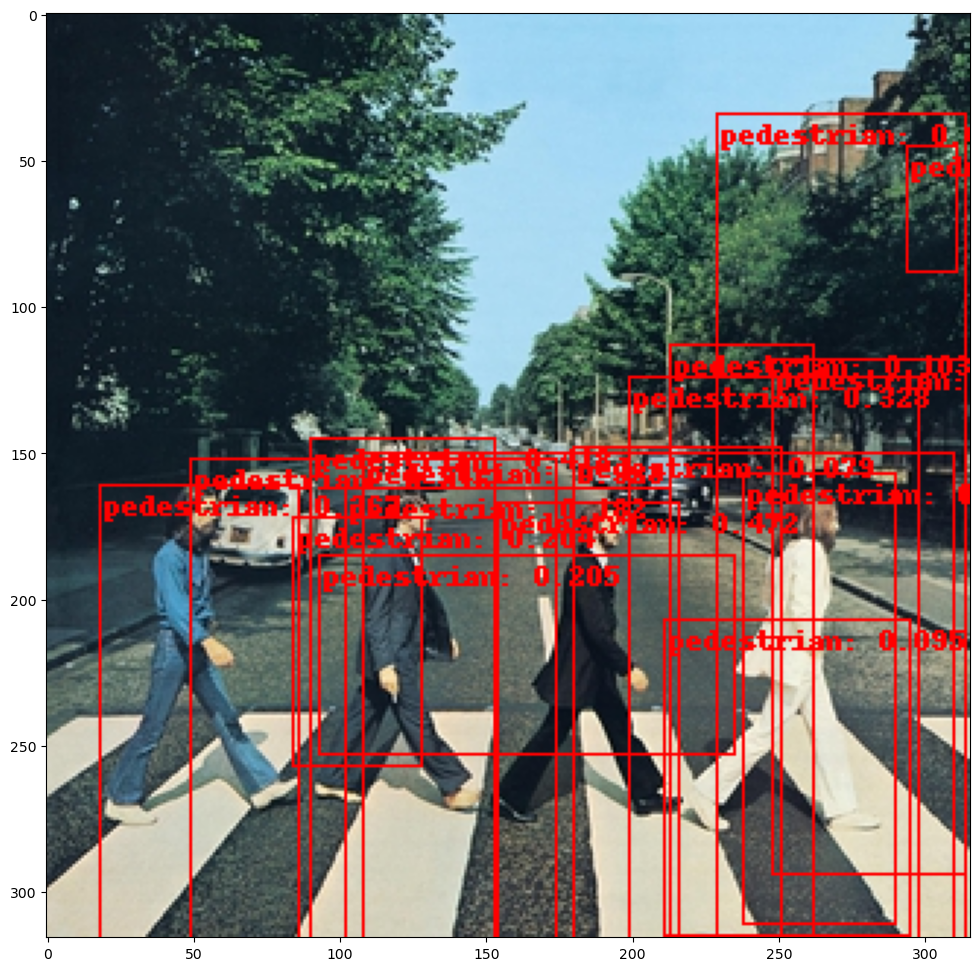

In [22]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("Beatles.jpg")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

#masks = (pred["masks"] > 0.7).squeeze(1)
#output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))